In [27]:
import torch
from torch import nn

class PICNN(nn.Module):
    def __init__(self,
            x_dimension: int,
            y_dimension: int,
            u_dimension: int,
            z_dimension: int,
            output_dimension: int,
            number_of_hidden_layers: int
        ):
        super(PICNN, self).__init__()


        # Activations:
        self.z_activation = nn.ELU()
        self.u_activation = nn.ELU()
        self.positive_activation = nn.ReLU()

        # First layer
        self.first_linear_layer_tilde = nn.Linear(x_dimension, u_dimension)
        self.first_linear_layer_yu = nn.Linear(x_dimension, y_dimension)
        self.first_linear_layer_y = nn.Linear(y_dimension, z_dimension, bias=False)
        self.first_linear_layer_u = nn.Linear(x_dimension, z_dimension, bias=False)

        # Iterations:
        self.linear_layer_tilde = nn.ModuleList([
                nn.Linear(u_dimension, u_dimension)
                for _ in range(number_of_hidden_layers)
        ])
        self.linear_layer_uz = nn.ModuleList([
            nn.Linear(u_dimension, z_dimension)
                for _ in range(number_of_hidden_layers)
        ])
        self.linear_layer_z = nn.ModuleList([
            nn.Linear(z_dimension, z_dimension)
                for _ in range(number_of_hidden_layers)
        ])
        self.linear_layer_uy = nn.ModuleList([
            nn.Linear(u_dimension, y_dimension)
                for _ in range(number_of_hidden_layers)
        ])
        self.linear_layer_y = nn.ModuleList([
            nn.Linear(y_dimension, z_dimension, bias=False)
                for _ in range(number_of_hidden_layers)
        ])
        self.linear_layer_u = nn.ModuleList([
            nn.Linear(u_dimension, z_dimension, bias=False)
                for _ in range(number_of_hidden_layers)
        ])
        self.number_of_hidden_layers = number_of_hidden_layers

        # Last layer:
        self.last_linear_layer_uz = nn.Linear(u_dimension, z_dimension)
        self.last_linear_layer_z = nn.Linear(z_dimension, output_dimension)
        self.last_linear_layer_uy = nn.Linear(u_dimension, y_dimension)
        self.last_linear_layer_y = nn.Linear(y_dimension, output_dimension, bias=False)
        self.last_linear_layer_u = nn.Linear(u_dimension, output_dimension, bias=False)


    def forward(self, x, y):
        # First layer:
        u = self.u_activation(
            self.first_linear_layer_tilde(x)
        )
        z = self.z_activation(
            self.first_linear_layer_y(
                y * self.first_linear_layer_yu(x)
            ) +
            self.first_linear_layer_u(x)
        )

        # Iterations:
        for iteration_number in range(self.number_of_hidden_layers):
            u, z = (
                self.u_activation(
                    self.linear_layer_tilde[iteration_number](u)
                ),
                self.z_activation(
                    self.linear_layer_z[iteration_number](
                        z * self.positive_activation((self.linear_layer_uz[iteration_number](u)))
                    ) + \
                    self.linear_layer_y[iteration_number](
                        y * self.linear_layer_uy[iteration_number](u)
                    ) + \
                    self.linear_layer_u[iteration_number](u)
                )
            )

        # Last layer:
        output = self.last_linear_layer_z(
            z * self.positive_activation(self.last_linear_layer_uz(u))
        ) + \
        self.last_linear_layer_y(
            y * self.last_linear_layer_uy(u)
        ) + \
        self.last_linear_layer_u(u)

        return output

def torch_sphere_uniform(n, d, **kwargs):
    """Generate n points inside the d-dimensional sphere."""
    random_vectors = torch.randn(n, d, **kwargs)
    vectors_norms = torch.norm(random_vectors, dim=1, keepdim=True)
    radius = torch.pow(torch.rand(n, 1, **kwargs), 1. / d)
    return radius * random_vectors / vectors_norms

In [ ]:
import numpy as np

seed = 0
dataset_name = "taxi"
dataset_path = f".data/{dataset_name}_seed_{seed}_samples.npz"

num_points_to_generate = 7800

with np.load(dataset_path) as npzf:
    print(f"{npzf["X_train"].shape=}")
    X = npzf["X_train"][:num_points_to_generate]
    Y = npzf["Y_train"][:num_points_to_generate]

n, d = Y.shape
m = n

nu = np.ones((n, 1)) / n
mu = np.ones((m, 1)) / m

print(f"{n=}, {d=}")

npzf["X_train"].shape=(7800, 6)
n=7800, d=2


In [55]:
phi_network = PICNN(
    x_dimension=X.shape[1],
    y_dimension=Y.shape[1],
    u_dimension=100,
    z_dimension=100,
    output_dimension=1,
    number_of_hidden_layers=1,
)


Shape of x: (7800, 6)
Shape of y: (7800, 2)
Min x value: -3.79, Max x value: 44.15


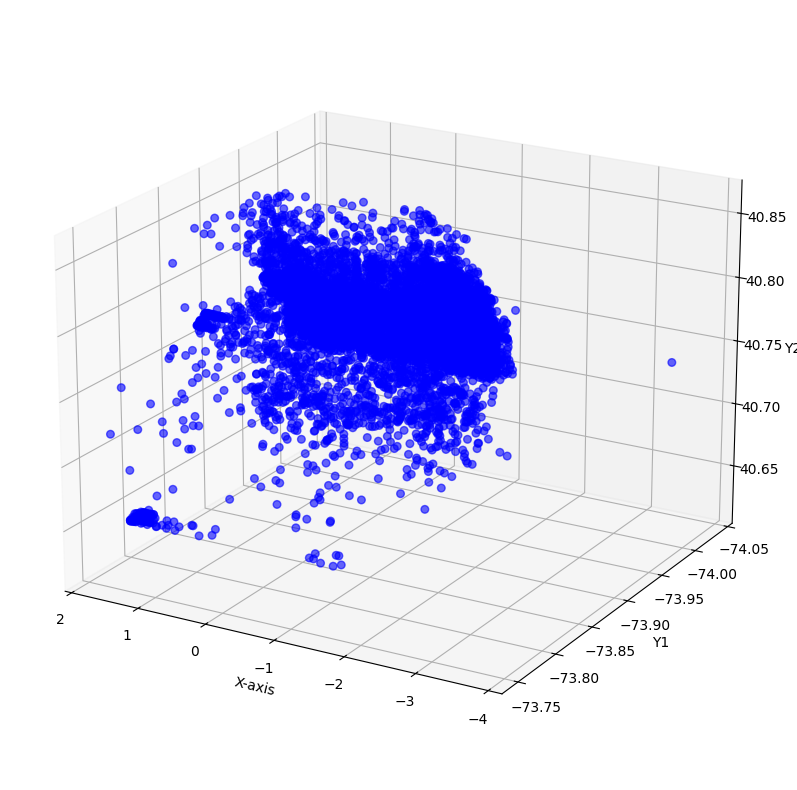

In [56]:
import matplotlib.pyplot as plt

%matplotlib inline

print(f"Shape of x: {X.shape}")
print(f"Shape of y: {Y.shape}")
print(f"Min x value: {np.min(X):.2f}, Max x value: {np.max(X):.2f}")


fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(X[:, 2], Y[:, 0], Y[:, 1], c='blue', marker='o', s=30, alpha=0.6)

ax.set_xlabel('X-axis')
ax.set_ylabel('Y1')
ax.set_zlabel('Y2')

ax.grid(True)
ax.view_init(elev=20, azim=120)

plt.show()

In [57]:
import torch
torch.manual_seed(0)

device_and_dtype_specifications = dict(dtype=torch.float64, device=torch.device("cpu"))
device_and_dtype_specifications = dict(dtype=torch.float64, device=torch.device("cuda"))
epsilon = 1e-5
num_epochs = 1000

phi_network.to(**device_and_dtype_specifications)
phi_network_optimizer = torch.optim.Adam([dict(params=phi_network.parameters())], lr=0.01)

#X, Y = create_joint_x_y(num_points_to_generate)
X_tensor = torch.tensor(X, **device_and_dtype_specifications)
Y_tensor = torch.tensor(Y, **device_and_dtype_specifications)
dataset_size = num_points_to_generate
batch_size = 256


def estimate_psi(X_tensor, Y_tensor, U_tensor, phi_net, epsilon=0.1):
        """
        Estimate the dual objective term for entropy estimation.

        This function implements the core calculation based on nearest neighbors and learned
        potential functions phi and psi. It offers an option to oversample some x's to better approximate P(Y|X)

        Args:
        X_tensor (torch.Tensor): The input tensor for x, with shape [n, p].
        Y_tensor (torch.Tensor): The input tensor for y, with shape [n, q].
        U_tensor (torch.Tensor): The tensor of oversampled variables u, with shape [m, q].
        phi_net (nn.Module): The neural network representing the potential function phi(u, x).
        psi_net (nn.Module): The neural network representing the potential function psi(x, y).
        k (int, optional): The number of nearest neighbors to use. Defaults to 5.
        epsilon (float, optional): A small positive constant for the calculation. Defaults to 0.1.

        Returns:
        torch.Tensor: A scalar tensor representing the estimated dual value.
        """
        # Get dimensions from input tensors
        n, _ = X_tensor.shape
        m, _ = U_tensor.shape

        U_expanded = U_tensor.unsqueeze(0).expand(n, -1, -1)  # Shape: [n, m, q] [:, i, :] = u_i
        X_expanded_for_U = X_tensor.unsqueeze(1).expand(-1, m, -1)  # Shape: [n, m, p] [i, :, :] = x_i

        phi_vals = phi_net(X_expanded_for_U, U_expanded).squeeze(-1)  # Shape: [n, m] [i, j] = phi(u_i, x_j)
        cost_matrix = Y_tensor @ U_tensor.T # Shape: [n, m] [i, j] = y_j @ u_i

        slackness = cost_matrix - phi_vals    # Shape: [n, m]

        log_mean_exp = torch.logsumexp(slackness / epsilon, dim=1, keepdim=True) \
                - torch.log(torch.tensor(m, device=slackness.device, dtype=slackness.dtype))

        psi_estimate = epsilon * log_mean_exp

        return psi_estimate


for epoch_idx in range(1, num_epochs):

        phi_network.zero_grad()

        yindexes = torch.randint(0, dataset_size, (batch_size,))

        X_batch = X_tensor[yindexes]
        Y_batch = Y_tensor[yindexes]
        U_batch = torch.randn(
                batch_size, Y_batch.shape[1],
                **device_and_dtype_specifications
        )

        phi = phi_network(x=X_batch, y=U_batch)
        psi = estimate_psi(
                X_tensor=X_batch,
                Y_tensor=Y_batch,
                U_tensor=U_batch,
                phi_net=phi_network,
                epsilon=epsilon
        )

        objective = torch.mean(phi) + torch.mean(psi)

        convexity_regularization = torch.sum(
                torch.stack([
                        torch.sum(torch.nn.functional.relu(-linear_layer_z.weight) ** 2) / 2
                        for linear_layer_z in phi_network.linear_layer_z
                ] + [
                        torch.sum(torch.nn.functional.relu(-phi_network.last_linear_layer_z.weight) ** 2) / 2
                ])
        )

        objective += convexity_regularization

        objective.backward()
        phi_network_optimizer.step()
        print(objective.item(), epoch_idx)

_ = phi_network.eval()

303.78397636177937 1
300.82793586214353 2
289.9812911264216 3
236.87932979169264 4
240.8795845949232 5


239.63218610917554 6
195.75379129669176 7
179.59774283624853 8
143.78549211237748 9
101.547380642689 10
81.60946430216961 11
105.35927281037156 12
90.30612414883358 13
84.49795250524703 14
43.25133111705486 15
42.7131573061579 16
27.718756177252363 17
40.466581990673156 18
47.3518808662728 19
34.90316541193872 20
29.981764400641513 21
31.546466042348488 22
30.567560286511693 23
26.55601817711914 24
34.1155351920343 25
41.41354119714707 26
24.57891584313894 27
20.249493065525876 28
23.29413981188442 29
26.704111577809158 30
26.926495771530245 31
10.704277254056716 32
10.81591451515798 33
15.844080106129763 34
16.596142745160098 35
13.539860652242425 36
16.480456391966488 37
16.93829192525989 38
14.47731654679214 39
4.759043926920398 40
15.763616399479758 41
17.644640962821708 42
5.276177929897569 43
9.034645812223715 44
19.419300872458876 45
5.52688460015991 46
5.79615768766294 47
10.504979025732085 48
7.680354427622662 49
13.705895788714832 50
11.916092924621461 51
5.867749347684853 52

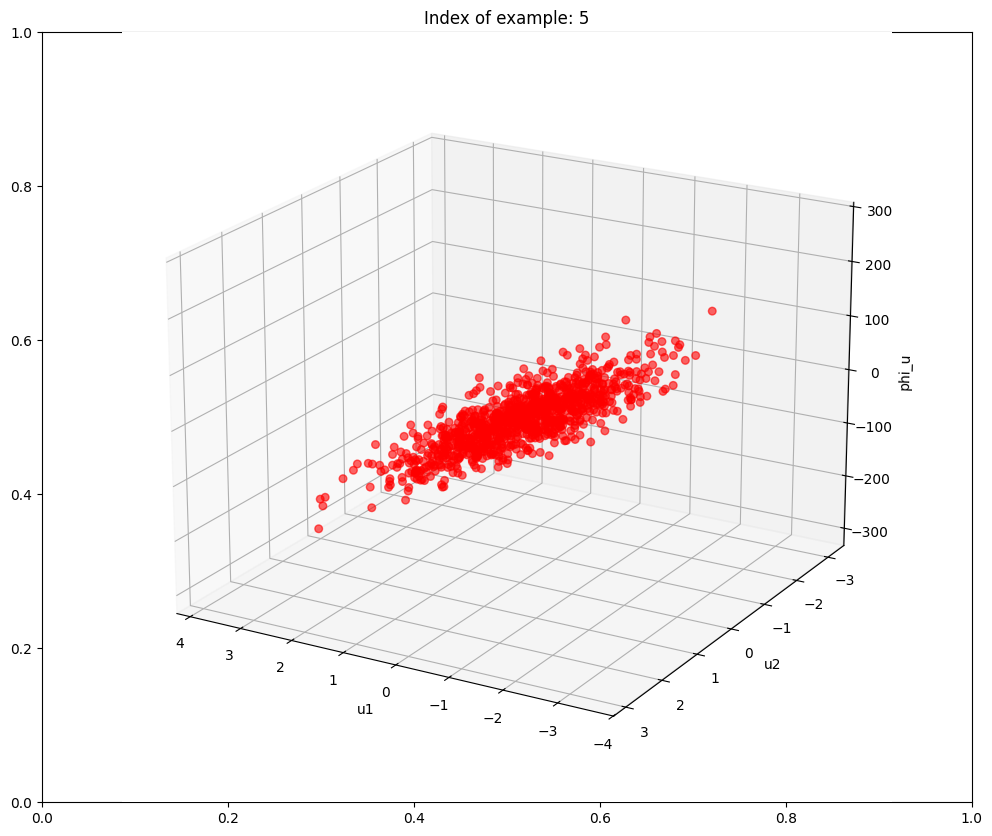

In [58]:
import matplotlib.pyplot as plt

%matplotlib inline

idx_point = 5

fig = plt.figure(figsize=(12, 10))
plt.title(f"Index of example: {idx_point}")
ax = fig.add_subplot(111, projection='3d')
number_of_points_to_visualize = 1000

with torch.no_grad():
        U_tensor = torch.randn(number_of_points_to_visualize, d, **device_and_dtype_specifications)
        UX_tensor = X_tensor[idx_point:(idx_point + 1)].repeat(number_of_points_to_visualize, 1)
        potential_tensor = phi_network(UX_tensor, U_tensor)

potential = potential_tensor.detach().cpu().numpy()
U = U_tensor.detach().cpu().numpy()
scatter = ax.scatter(U[:, 0], U[:, 1], potential.squeeze(), color='red', marker='o', s=30, alpha=0.6)
ax.grid(True)

ax.view_init(elev=20, azim=120)
ax.set_xlabel('u1')
ax.set_ylabel('u2')
ax.set_zlabel('phi_u')

plt.show()

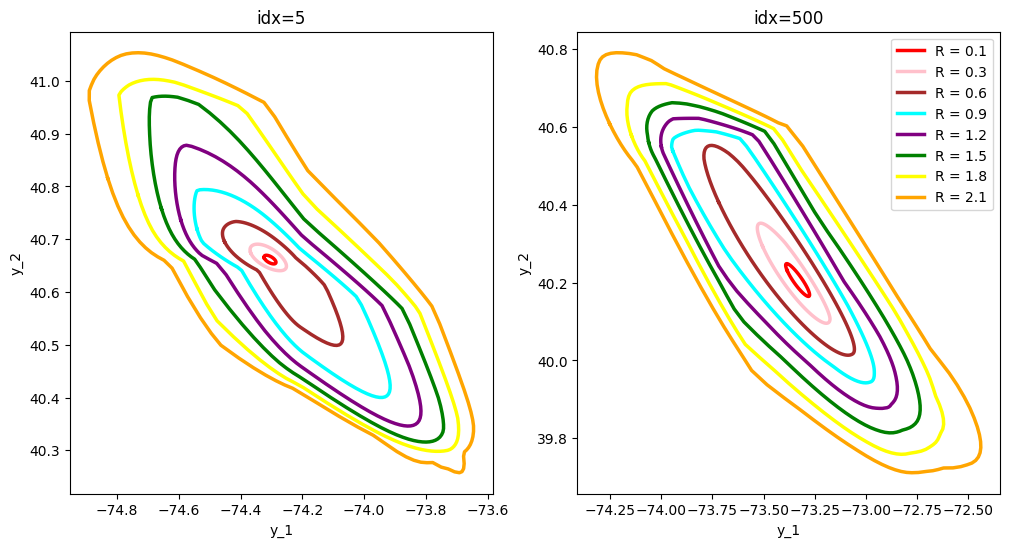

In [59]:
# Change to %matplotlib qt to have interactive plots
%matplotlib inline
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
num_angles = 100

for ax, idx in zip ((ax1, ax2), (5, 500)):
    ax.set_title(f'{idx=}')
    ax.set_xlabel('y_1')
    ax.set_ylabel('y_2')
    x = X_tensor[idx:(idx + 1)]
    x = x.repeat(num_angles, 1)


    colors = ['red', 'pink', 'brown', 'cyan', 'purple', 'green', 'yellow', "orange"]
    radii = [0.1, 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 5]
    for contour_radius, color in zip(radii, colors):
        pi_tensor = torch.linspace(-torch.pi, torch.pi, num_angles)
        u_tensor = torch.stack([
            contour_radius * torch.cos(pi_tensor),
            contour_radius * torch.sin(pi_tensor),
        ], dim=1)

        u_tensor = u_tensor.to(**device_and_dtype_specifications)
        u_tensor.requires_grad = True


        potential = phi_network(x, u_tensor)
        pushforward_of_u = torch.autograd.grad(potential.sum(), u_tensor)[0]

        ax.plot(pushforward_of_u[:, 0].numpy(force=True), pushforward_of_u[:, 1].numpy(force=True), 
                color=color, linewidth=2.5, label=f"R = {contour_radius}")

plt.legend()
plt.show()

Mapping code adapted from https://makersportal.com/blog/2020/4/24/geographic-visualizations-in-python-with-cartopy

In [18]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy.io.img_tiles as cimgt
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import io
from urllib.request import urlopen, Request
from PIL import Image

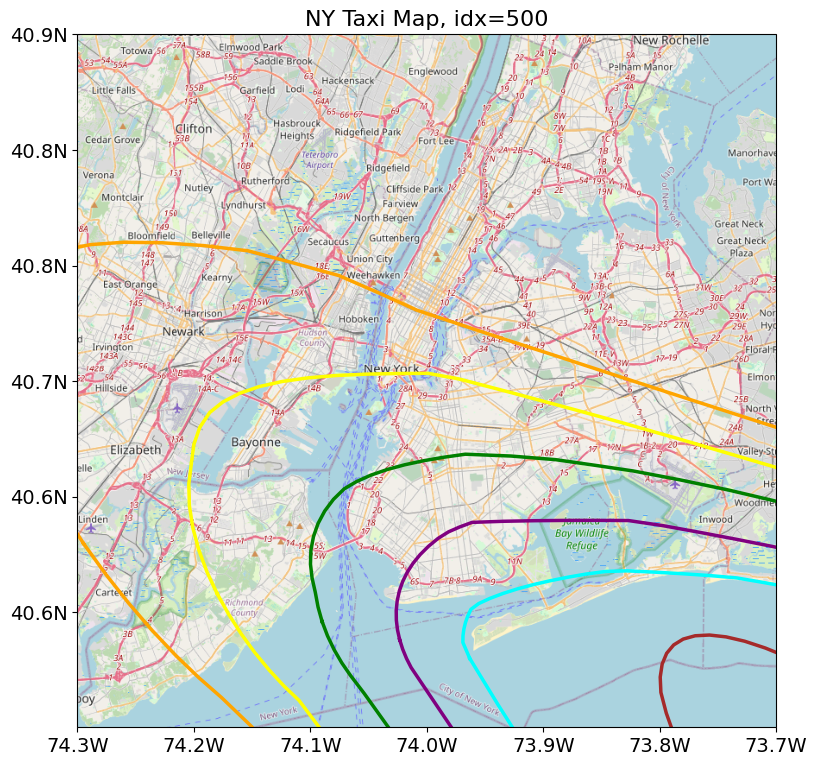

In [ ]:
osm_img = cimgt.OSM(cache=True)
extent = [-74.257159, -73.699215, 40.495992, 40.915568] # NYC bounds

%matplotlib inline

fig = plt.figure(figsize=(12, 9)) # open matplotlib figure
ax1 = plt.axes(projection=osm_img.crs) # project using coordinate reference system (CRS) of street map
ax1.set_extent(extent) # set extents
ax1.set_xticks(np.linspace(extent[0], extent[1], 7), crs=ccrs.PlateCarree()) # set longitude indicators
ax1.set_yticks(np.linspace(extent[2], extent[3], 7)[1:], crs=ccrs.PlateCarree()) # set latitude indicators
lon_formatter = LongitudeFormatter(number_format='0.1f', degree_symbol='',dateline_direction_label=True) # format lons
lat_formatter = LatitudeFormatter(number_format='0.1f', degree_symbol='') # format lats
ax1.xaxis.set_major_formatter(lon_formatter) # set lons
ax1.yaxis.set_major_formatter(lat_formatter) # set lats
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)

scale = np.ceil(-np.sqrt(2)  *np.log(np.divide((extent[1] - extent[0]) / 2.0, 350.0))) # empirical solve for scale based on zoom
scale = (scale < 20) and scale or 19 # scale cannot be larger than 19
ax1.add_image(osm_img, int(scale)) # add OSM with zoom specification

idx = 500
ax1.set_title(f'NY Taxi Map, {idx=}', fontsize=16)
x = X_tensor[idx:(idx + 1)]
x = x.repeat(num_angles, 1)


colors = ['red', 'pink', 'brown', 'cyan', 'purple', 'green', 'yellow', "orange"]
radii = [0.1, 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 5]
for contour_radius, color in zip(radii, colors):
    pi_tensor = torch.linspace(-torch.pi, torch.pi, num_angles)
    u_tensor = torch.stack([
        contour_radius * torch.cos(pi_tensor),
        contour_radius * torch.sin(pi_tensor),
    ], dim=1)

    u_tensor = u_tensor.to(**device_and_dtype_specifications)
    u_tensor.requires_grad = True


    potential = phi_network(x, u_tensor)
    pushforward_of_u = torch.autograd.grad(potential.sum(), u_tensor)[0]

    ax1.plot(pushforward_of_u[:, 0].numpy(force=True), pushforward_of_u[:, 1].numpy(force=True), 
             transform=ccrs.PlateCarree(), color=color, linewidth=2.5, label=f"R = {contour_radius}")
